# Legal Text Classification for Document Categorization in Law


In [2]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


# Imported the necessary libraries

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

# Download NLTK resources

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sowja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sowja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sowja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The "TextClassifier" model employs bidirectional LSTM layers for text classification, utilizing embeddings, dropout, and fully connected layers to process input sequences and produce output logits.

In [6]:
# TextClassifier class to use LSTM
class TextClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) 
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        lstm_out = torch.cat((lstm_out[:, -1, :hidden_dim], lstm_out[:, 0, hidden_dim:]), dim=1)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        return output

Defined CustomDataset to manage the input data and corresponding labels for training the model. These components together enable the training and evaluation of the text classification model in a PyTorch environment.

In [7]:
# Defining a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 1: Data Collection

In [10]:
# Load the data in chunks
chunk_size = 100 
data = pd.read_csv("legal_data.csv", chunksize=chunk_size)

# Concatenate the chunks
data = pd.concat(data, ignore_index=True)

# Drop rows with columns named 'Unnamed'
data = data.drop(data.filter(regex='Unnamed:').columns, axis=1)

In [11]:
data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


# Step 2: Data Preprocessing

In [12]:
X = data['case_text']
y = data['case_outcome']

In [15]:
# Convert text data to strings
data['case_text'] = data['case_text'].astype(str)

# Drop rows with missing values
data.dropna(subset=["case_text", "case_outcome"], inplace=True)

This code snippet creates a word cloud visualization based on a sample of legal documents. It first loads a subset of the data, then generates word frequencies from the 'case_text' column using the Counter class. Next, it utilizes the WordCloud library to construct the word cloud, setting parameters for width, height, and background color. Finally, the resulting word cloud is displayed using Matplotlib. This visualization offers a graphical representation of the most frequently occurring words in the legal documents.


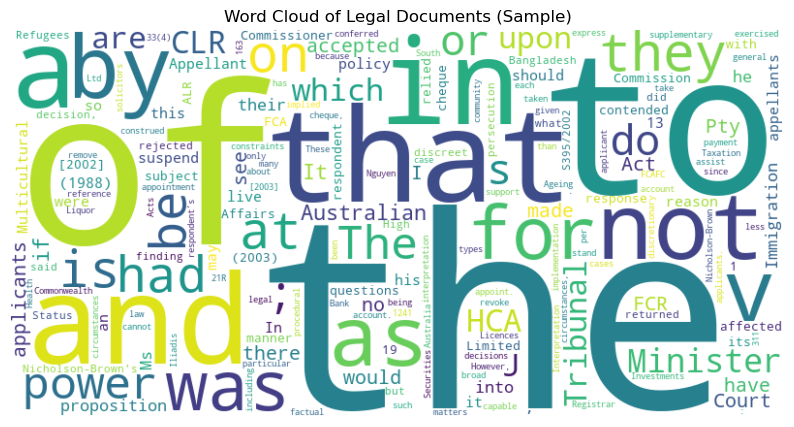

In [12]:
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# Load a sample of the data
data_sample = data.sample(frac=0.1)  

# Create a word cloud
word_freq = Counter(" ".join(data_sample['case_text']).split())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Legal Documents (Sample)')
plt.show()


This code converts the text data in the 'case_text' column of the dataset to strings, ensuring consistent data type. Subsequently, it visualizes the distribution of document lengths by calculating the number of words in each document. Matplotlib and Seaborn libraries are utilized to create a histogram plot, showing the frequency of document lengths across 20 bins. This visualization provides insights into the distribution of document lengths within the dataset.


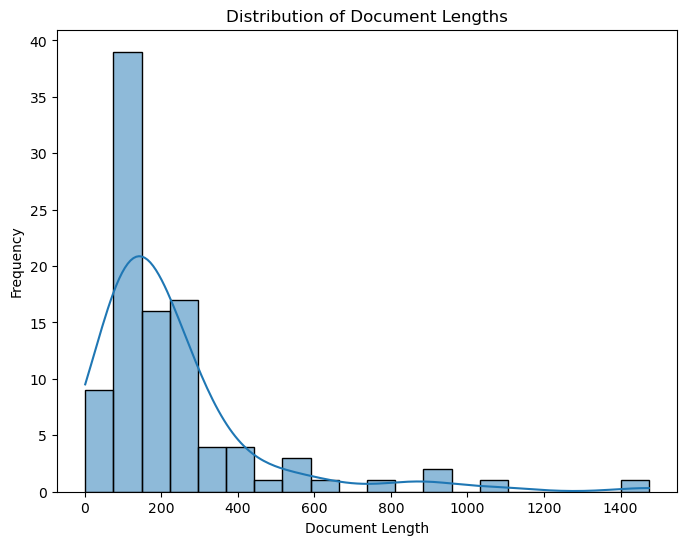

In [13]:
# Convert text data to strings
data['case_text'] = data['case_text'].astype(str)

# Plot document length distribution
doc_lengths = data['case_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(doc_lengths, bins=20, kde=True)
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')
plt.show()


Below code initializes a set of English stopwords and a WordNet lemmatizer, which are commonly used for text preprocessing tasks like tokenization, removing stopwords, and lemmatization.

In [14]:
# Tokenization, stopword removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

Implemented "preprocess_text" function which takes a text input, tokenizes it into words, converts them to lowercase, lemmatizes them, removes any non-alphabetic tokens and stopwords, and finally returns the preprocessed text as a string. If the input is not a string (e.g., missing value), it returns an empty string.

In [15]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string
        tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
        tokens = [token for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
        tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
        tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
        return ' '.join(tokens)
    else:
        return ''  # Return empty string for missing values

In [16]:
#Preprocess each text element in X by tokenization, lowercasing, lemmatization, and stopword removal.
X = X.apply(preprocess_text)

# Step 3: Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Extraction

Below code converts text data to numerical form and prepares it for training models in PyTorch. It uses "TF-IDF vectorization" to convert text to numerical features, then converts them into PyTorch tensors. It also encodes categorical labels and converts them to PyTorch tensors.

In [18]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to PyTorch tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.int64)

# Step 5: Model Training

Below code defines and trains a text classification model. It set up the model architecture, loss function, and optimizer. Then, it prepares the data loader for batching and trains the model for multiple epochs while tracking the training loss.

In [19]:
import matplotlib.pyplot as plt

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
input_dim = X_train_tensor.shape[1]
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Initialize the model, loss function, and optimizer
model = TextClassifier(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define DataLoader for batching
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.long())
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 1.8760
Epoch [2/10], Loss: 1.4263
Epoch [3/10], Loss: 1.5137
Epoch [4/10], Loss: 1.5186
Epoch [5/10], Loss: 1.3201
Epoch [6/10], Loss: 1.3886
Epoch [7/10], Loss: 1.2209
Epoch [8/10], Loss: 1.5498
Epoch [9/10], Loss: 1.4092
Epoch [10/10], Loss: 1.4832


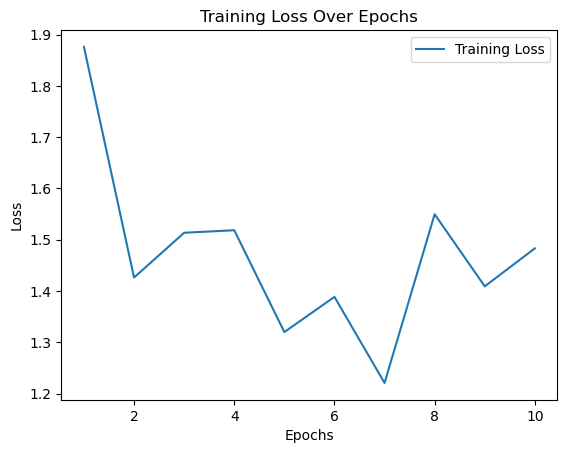

In [20]:
# Plot training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [21]:
# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.long())
    _, predicted = torch.max(outputs, 1)

# Calculate accuracy
accuracy = torch.sum(predicted == y_test_tensor).item() / len(y_test_tensor)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6500


# Step 6: Model Evaluation

Below code evaluates the trained PyTorch RNN model on the test dataset. It uses the model to predict the outcomes for the test data and calculates evaluation metrics such as accuracy, precision, recall, F1 score, and confusion matrix. Finally, it prints out these evaluation metrics.

In [22]:
import torch

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reduce batch size
batch_size = 16

# Move tensors to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Evaluate model in batches
with torch.no_grad():
    model.eval()
    predictions = []
    for i in range(0, len(X_test_tensor), batch_size):
        batch_X = X_test_tensor[i:i+batch_size]
        batch_y = y_test_tensor[i:i+batch_size]
        outputs = model(batch_X.long())
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())  # Move predictions back to CPU for processing

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predictions)
precision = precision_score(y_test_tensor.cpu().numpy(), predictions, average='weighted')
recall = recall_score(y_test_tensor.cpu().numpy(), predictions, average='weighted')
f1 = f1_score(y_test_tensor.cpu().numpy(), predictions, average='weighted')
conf_matrix = confusion_matrix(y_test_tensor.cpu().numpy(), predictions)

print("\n LSTM Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)



 LSTM Model Evaluation Metrics:
Accuracy: 0.65
Precision: 0.42250000000000004
Recall: 0.65
F1 Score: 0.5121212121212122
Confusion Matrix:
[[13  0  0  0]
 [ 1  0  0  0]
 [ 5  0  0  0]
 [ 1  0  0  0]]


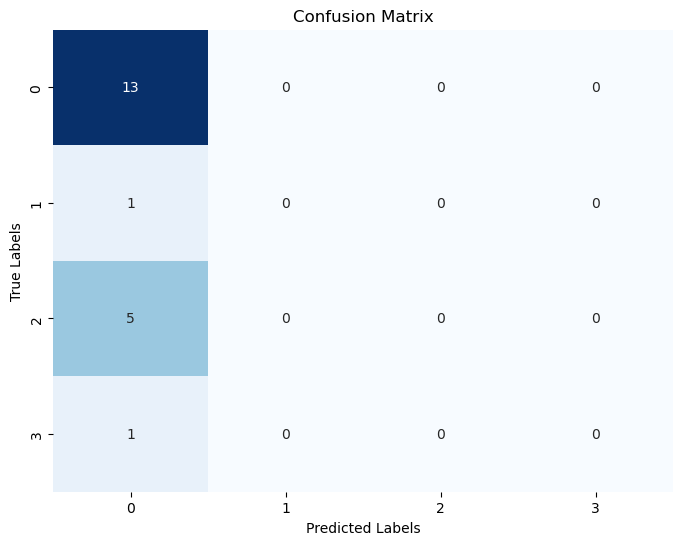

In [23]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Step 7: Save the trained model

Below code saves the trained model's weights to a file named "legal_text_classifier.pth". Then, it loads the model's architecture and trained weights from the saved file. Finally, it sets the model to evaluation mode

In [24]:
import torch
torch.save(model.state_dict(), 'legal_text_classifier.pth')
# Load the model architecture
model = TextClassifier(input_dim, embedding_dim, hidden_dim, output_dim)
# Load the trained weights
model.load_state_dict(torch.load('legal_text_classifier.pth'))
# Set the model to evaluation mode
model.eval()


TextClassifier(
  (embedding): Embedding(1840, 100)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

# Real World Model Application

Below code implemented using SVM, specifically Linear SVC, for text classification. It loads legal text data, extracts features using TF-IDF, trains the SVM model, and creates a simple UI for users to input text for classification. When the user inputs text, the model predicts the outcome category and displays it.

In [25]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import pandas as pd

# Load the dataset
data = pd.read_csv("legal_data.csv")

# Drop rows with missing values in the "case_text" and "case_outcome" columns
data.dropna(subset=["case_text", "case_outcome"], inplace=True)

# Extract relevant columns
legal_texts = data["case_text"]
categories = data["case_outcome"].unique()  # Get unique categories from the data

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the data
X = tfidf_vectorizer.fit_transform(legal_texts)
y = data["case_outcome"]

# Train a Linear SVC classifier
classifier = LinearSVC()
classifier.fit(X, y)

# Create text input widget
text_input = widgets.Textarea(
    placeholder="Enter legal text here",
    description="Legal Text:",
    layout=widgets.Layout(width="50%", height="150px")
)

# Create output widget for displaying prediction
output = widgets.Output()

# Function to classify text and display result
def classify_text(text):
    text_features = tfidf_vectorizer.transform([text])
    prediction = classifier.predict(text_features)[0]
    with output:
        output.clear_output()
        print("Predicted Outcome:", prediction)

# Event handler for button click
def on_button_clicked(b):
    classify_text(text_input.value)

# Create button widget
classify_button = widgets.Button(description="Classify")
classify_button.on_click(on_button_clicked)

# Display widgets
display(text_input, classify_button, output)


Textarea(value='', description='Legal Text:', layout=Layout(height='150px', width='50%'), placeholder='Enter l…

Button(description='Classify', style=ButtonStyle())

Output()

# Using Random Forest Classifier for Legal Text Classification

Below code implemented to predict the outcome of a legal text using a pre-trained Random Forest classifier.
It takes a legal text as input, transforms it into features using a TF-IDF vectorizer, and then predicts the outcome using the Random Forest model. Finally, it compares the predicted outcome with the actual outcome from the dataset and prints both outcomes.

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score

The `load_data()` function reads a dataset from a CSV file specified by `file_path` using pandas `read_csv` function and returns the loaded data.

The `preprocess_data()` function takes a DataFrame `data` as input and preprocesses text data for machine learning tasks. It drops rows with missing values in the "case_text" and "case_outcome" columns using `dropna()`. Then, it splits the data into training and testing sets using `train_test_split()` from scikit-learn, with a test size of 20% and a random state of 42 for reproducibility. It further applies TF-IDF vectorization to the text data using `TfidfVectorizer` from scikit-learn, with a maximum number of features set to 5000. It returns the TF-IDF transformed training and testing data, along with corresponding labels and the TF-IDF vectorizer.

In [27]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    data.dropna(subset=["case_text", "case_outcome"], inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(data["case_text"], data["case_outcome"], test_size=0.2, random_state=42)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf, y_train, y_test, tfidf_vectorizer


Trains a Random Forest classifier on the provided data and returns the trained model.

In [28]:
def train_model(X_train, y_train):
    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.fit(X_train, y_train)
    return rf_classifier

Predicts the outcome for a sample text using the provided model and TF-IDF vectorizer.
Evaluates the model using F1 score, precision, and accuracy metrics.

In [29]:
def predict_outcome(sample_text, model, vectorizer):
    sample_text_tfidf = vectorizer.transform([sample_text])
    predicted_outcome = model.predict(sample_text_tfidf)[0]
    return predicted_outcome

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    accuracy = model.score(X_test, y_test)
    return f1, precision, accuracy


Loads data from a CSV file, preprocesses it, trains a model, predicts the outcome for a sample text, and evaluates the model's performance using F1 score, precision, and accuracy metrics.


In [30]:
def randomclassifier():
    
    file_path = "legal_data.csv"
    data = load_data(file_path)
    
    # Preprocess data
    X_train, X_test, y_train, y_test, tfidf_vectorizer = preprocess_data(data)
    
    # Train model
    model = train_model(X_train, y_train)
    
    # Sample text input for prediction
    sample_text = "The preceding general principles inform the exercise of the discretion. That discretion is not to be fettered by transformation of approaches and practices developed through the cases into quasi statutory rules. In John S Hayes &amp; Associates Pty Ltd v Kimberly-Clark Australia Pty Ltd (1994) 52 FCR 201 , Hill J said (at 203): care must be taken not to circumscribe the discretion by reference to closed categories. It is not a necessary condition of the power to award costs that a collateral purpose be shown. The categories warranting the exercise of the discretion are not closed ... See also Goldberg J in Dr Martens Australia Pty Ltd v Figgins Holdings Pty Ltd (No 2) [2000] FCA 602 at [15] ."

    # Predict outcome for sample text
    predicted_outcome = predict_outcome(sample_text, model, tfidf_vectorizer)
    
    # Evaluate model
    f1, precision, accuracy = evaluate_model(model, X_test, y_test)
    
    print("Sample Text:", sample_text)
    print("Predicted Outcome:", predicted_outcome)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Accuracy:", accuracy)

In [31]:
randomclassifier()

Sample Text: The preceding general principles inform the exercise of the discretion. That discretion is not to be fettered by transformation of approaches and practices developed through the cases into quasi statutory rules. In John S Hayes &amp; Associates Pty Ltd v Kimberly-Clark Australia Pty Ltd (1994) 52 FCR 201 , Hill J said (at 203): care must be taken not to circumscribe the discretion by reference to closed categories. It is not a necessary condition of the power to award costs that a collateral purpose be shown. The categories warranting the exercise of the discretion are not closed ... See also Goldberg J in Dr Martens Australia Pty Ltd v Figgins Holdings Pty Ltd (No 2) [2000] FCA 602 at [15] .
Predicted Outcome: cited
F1 Score: 0.777051282051282
Precision: 0.8533333333333333
Accuracy: 0.8
